# Predicting the Programming Languages of the Most Starred Github Repos
**by Daniel Guerrero and Yvonne King**

**Quick Notebook Reference**

1. Project Plan
2. Imports
3. Acquire
4. Prep
5. Exploration
6. Models
7. Model Evaluation
8. Final Conclusions

## Project Plan

**Acquisition, Prep, and Initial Exploration**
- Fetch Data from local cache
- Handle Missing Values
- Remove/repair erroneous data
- Look at shape of data
- normalize data by removing non ASCII characters
- tokenize words
- stem and lemmatize words
- remove stop words

**Exploration**

- Answer the following questions:
    - What are the most common words in READMEs?
    - What does the distribution of IDFs look like for the most common words?
    - Does the length of the README vary by programming language?
    - Do different programming languages use a different number of unique words?
    
**Modeling**
- Build a model that can predict what programming language a repository is, based on the text of the README file

### Main Hypothesis:

Given that we are asked to predict the type of programming language being used, based on the contents of the README, we think that the following strategies will help us be successful.

1. Hopefully, the majority of the README's will actually mention the programming language used, which can help the model better predict the target variable. 
1. Hopefully, there will also be a distinction in the length of the README's, as ceirtain programming languages are know to be more verbose than others, and the community that uses these languages usually mirors that. We will look to see if this is represented in that data, and is something that can be used for modeling.
1. Given the large number of programming languages available, it might be better to actually group some of the languages together, so that we can reduce the number of target variables. 

**Hypothesis**

Given the scale of the corpus, we predict that the TF-IDF will help us identify those words that appear most in a document, and give us an indication of how unique those words are among the different documents, helping the model more easily identify what key words are important when classifying individual documents. 

* $H_0$: The TF-IDF will not be the best feature for modeling.  
* $H_a$: The TF-IDF will be the best feature for modeling.  




## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import re

from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
from scipy import stats


import seaborn as sns
import matplotlib.pyplot as plt


import nltk
import nltk.sentiment
from wordcloud import WordCloud

import acquire
import prepare
import explore
import model

## Acquire
- We ran the acquire.py file in command line to generate the json file that we used to save on computing time
    - This file has functions that scrape Githup repos and pull in the readme file contents along with the programming language of the repo
- Fetched data from local cache

In [2]:
#read in data
df = pd.read_json("data.json")

In [3]:
#take a look at the shape of our data
df.shape

(790, 3)

In [4]:
#check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 3 columns):
repo               790 non-null object
language           695 non-null object
readme_contents    788 non-null object
dtypes: object(3)
memory usage: 18.6+ KB


In [5]:
#look at dataframe structure
df.head(5)

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US)\n=======\n*...
2,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ..."
3,EbookFoundation/free-programming-books,None,This page is available as an easy-to-read webs...
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...


## Prep
Using the prep_readme_function we will:
- normalize data by removing non ASCII characters
- tokenize words
- lemmatize words
- remove stop words

In [6]:
#function to prepare our data for modeling
df = prepare.prep_readme_data(df)

In [7]:
df.describe()

,repo,language,readme_contents,clean_tokes,clean_lemmatized
count,790,695,788,790,790
unique,619,35,617,618,617
top,testerSunshine/12306,JavaScript,![Huginn](https://raw.github.com/huginn/huginn...,"[img, srchttpsrawgithubusercontentcomswaggerap...",12306 python 2710 2715 x 36 374 279 x x x x x ...
freq,4,257,4,4,4


In [8]:
#look at dataframe structure
df.head(5)

,repo,language,readme_contents,clean_tokes,clean_lemmatized
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,"[freecodecamporg, social, bannerhttpss3amazona...",social pull request open source setup opensour...
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US) ======= **P...,"[996icuhttps996icuen_us, please, note, that, t...",please note exists official account app mercha...
2,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...","[p, aligncentera, hrefhttpsvuejsorg, target_bl...",p aligncentera target_blank relnoopener width1...
3,EbookFoundation/free-programming-books,None,This page is available as an easy-to-read webs...,"[this, page, is, available, as, an, easytoread...",page available easytoread website list free le...
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,"[reacthttpsreactjsorg, middot, github, license...",middot github npm circleci pr react javascript...


In [9]:
#Take a look at languages
df.language.value_counts(dropna=False)

JavaScript          257
NaN                  95
Python               83
Java                 53
Go                   41
TypeScript           40
C++                  35
C                    20
Swift                20
Shell                16
HTML                 14
Ruby                 13
Kotlin               13
PHP                  13
CSS                  12
C#                    8
Jupyter Notebook      7
Vue                   6
Vim script            6
Rust                  6
Dart                  5
TeX                   4
Objective-C           4
CoffeeScript          3
Haskell               2
Assembly              2
Lua                   2
Elixir                2
OCaml                 1
Dockerfile            1
Objective-C++         1
VimL                  1
Julia                 1
Clojure               1
Rascal                1
Makefile              1
Name: language, dtype: int64

- There are a few missing rows that are missing the programming language so will drop this columns by using the prepare_data function from prepare.py
- ALso based on the first glance of the language distrobutions we have decided to go with the more poplular languages JavaScript, Python, Java, C++ and have combined all other languages into a new variable other

In [10]:
df.readme_contents = df.readme_contents.dropna()

In [11]:
#drop na and create is_top_language column
df = prepare.prepare_data(df)

In [12]:
#peek at the datafram
df.head(5)

,repo,language,readme_contents,clean_tokes,clean_lemmatized,is_top_language
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,"[freecodecamporg, social, bannerhttpss3amazona...",social pull request open source setup opensour...,JavaScript
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US) ======= **P...,"[996icuhttps996icuen_us, please, note, that, t...",please note exists official account app mercha...,other
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,"[reacthttpsreactjsorg, middot, github, license...",middot github npm circleci pr react javascript...,JavaScript
14,airbnb/javascript,JavaScript,# Airbnb JavaScript Style Guide() { *A mostly...,"[airbnb, javascript, style, guide, a, mostly, ...",airbnb javascript style guide mostly reasonabl...,JavaScript
15,flutter/flutter,Dart,# [![Flutter logo][]][flutter.dev] [![Build S...,"[flutter, logoflutterdev, build, status, cirru...",flutter build status cirrusbuild status gitter...,other


In [13]:
#Take a look at languages again using our new column
df.is_top_language.value_counts(dropna=False)

other         202
JavaScript    151
Python         63
Java           49
C++            30
Name: is_top_language, dtype: int64

In [14]:
# Let's add some numerical features that we can use for the exploration phase

df["word_count"] = df.clean_lemmatized.apply(explore.word_count)
df["digit_count"] = df.clean_lemmatized.apply(explore.digit_count)

In [15]:
df.head()

,repo,language,readme_contents,clean_tokes,clean_lemmatized,is_top_language,word_count,digit_count
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,"[freecodecamporg, social, bannerhttpss3amazona...",social pull request open source setup opensour...,JavaScript,529,17
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US) ======= **P...,"[996icuhttps996icuen_us, please, note, that, t...",please note exists official account app mercha...,other,428,35
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,"[reacthttpsreactjsorg, middot, github, license...",middot github npm circleci pr react javascript...,JavaScript,286,0
14,airbnb/javascript,JavaScript,# Airbnb JavaScript Style Guide() { *A mostly...,"[airbnb, javascript, style, guide, a, mostly, ...",airbnb javascript style guide mostly reasonabl...,JavaScript,6503,625
15,flutter/flutter,Dart,# [![Flutter logo][]][flutter.dev] [![Build S...,"[flutter, logoflutterdev, build, status, cirru...",flutter build status cirrusbuild status gitter...,other,274,4


In [16]:
# Remove outliers

df = df[df.word_count < 7000]

In [17]:
# What's the shape of our final dataset?
df.shape

(486, 8)

## Exploration

### Distribution of Data
- Here we looked at the distribution of data so we could get a feel for the data

In [18]:
# Quick dataframe to view the distribution of all languages
pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize=True)], axis=1
    ).set_axis(['n', 'percent'], axis=1, inplace=False)

,n,percent
JavaScript,147,0.302469
Python,60,0.123457
Java,49,0.100823
C++,30,0.061728
Go,29,0.059671
TypeScript,26,0.053498
C,20,0.041152
Shell,13,0.026749
Kotlin,13,0.026749
Ruby,12,0.024691


In [19]:
# Quick dataframe to view the distribution of our top languages
pd.concat(
    [df.is_top_language.value_counts(), df.is_top_language.value_counts(normalize=True)], axis=1
    ).set_axis(['n', 'percent'], axis=1, inplace=False)

,n,percent
other,200,0.411523
JavaScript,147,0.302469
Python,60,0.123457
Java,49,0.100823
C++,30,0.061728


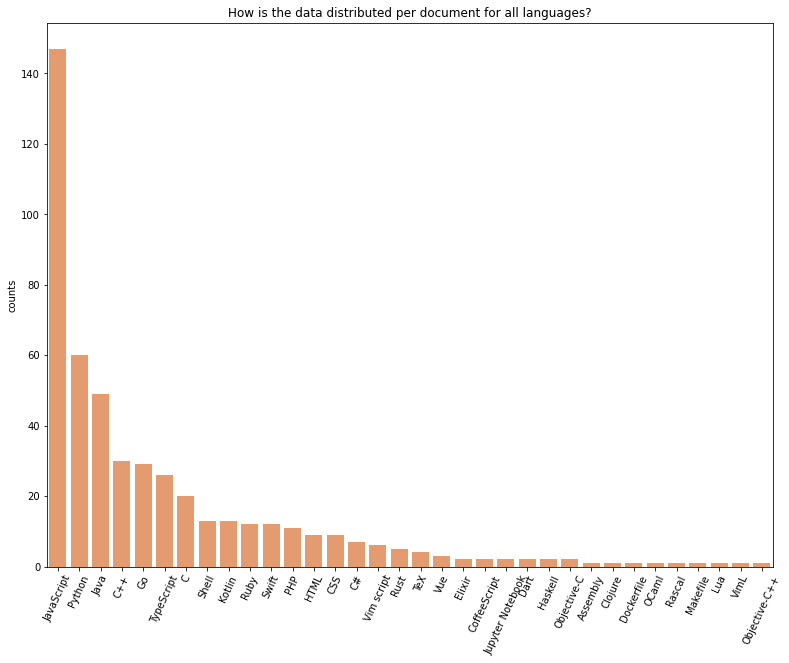

In [20]:
#plot the distros for all languages
explore.plot_distro_for_value_counts_all(df)

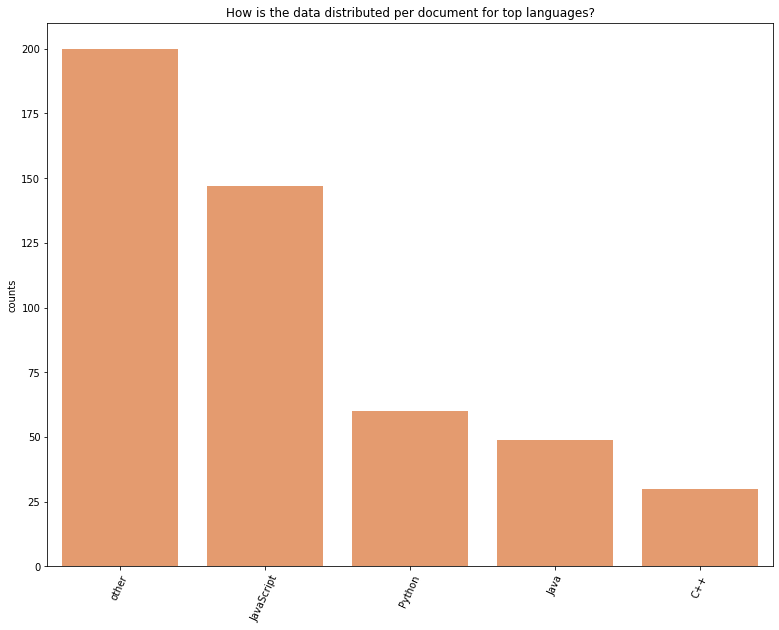

In [21]:
#plot the distros for top languages
explore.plot_distro_for_value_counts_top(df)

### REAMDE lengths by language

**Question Asked:** 

Does the length of the README vary by programming language?

**Answers** 
- It looks like most readmes have under 25k characters
- Pyhton and Swift seem to have a few outliers
- Overall the length of the readme's seem to be relatively similar

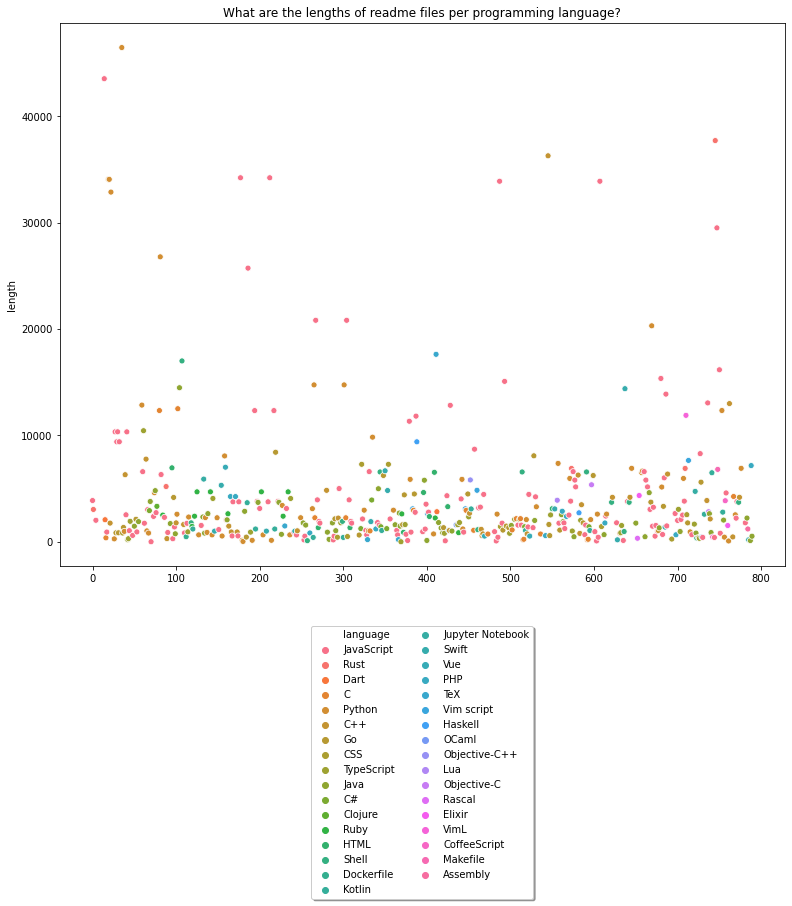

In [22]:
#scatterplot visual of the various readmes lengths hued language
explore.scatterplot_for_readmes(df)

#### Lets take a look at the medians, min, and max

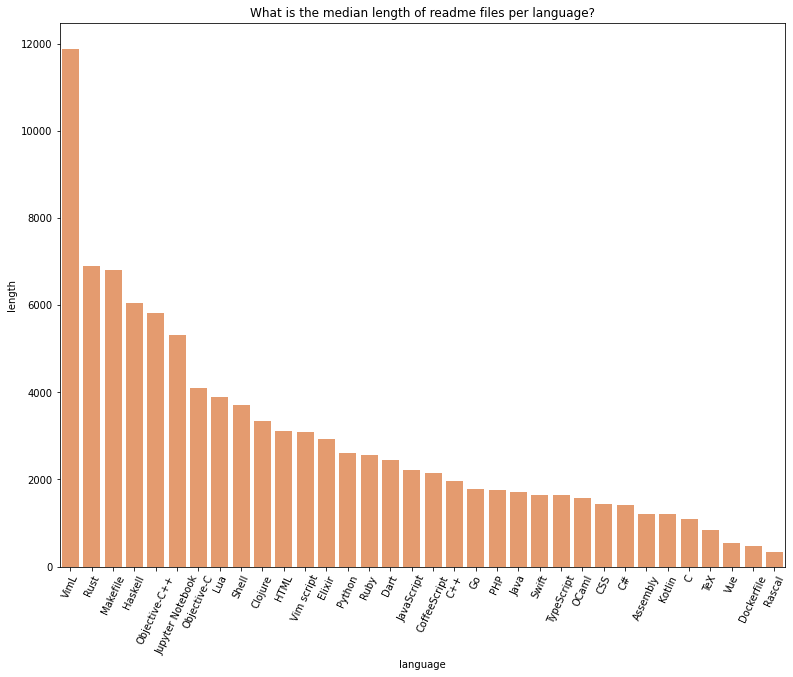

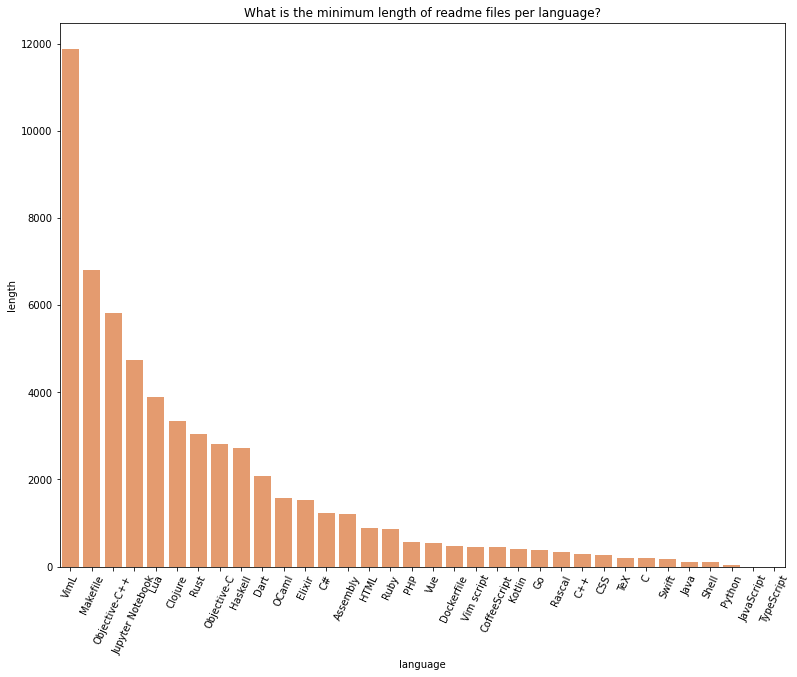

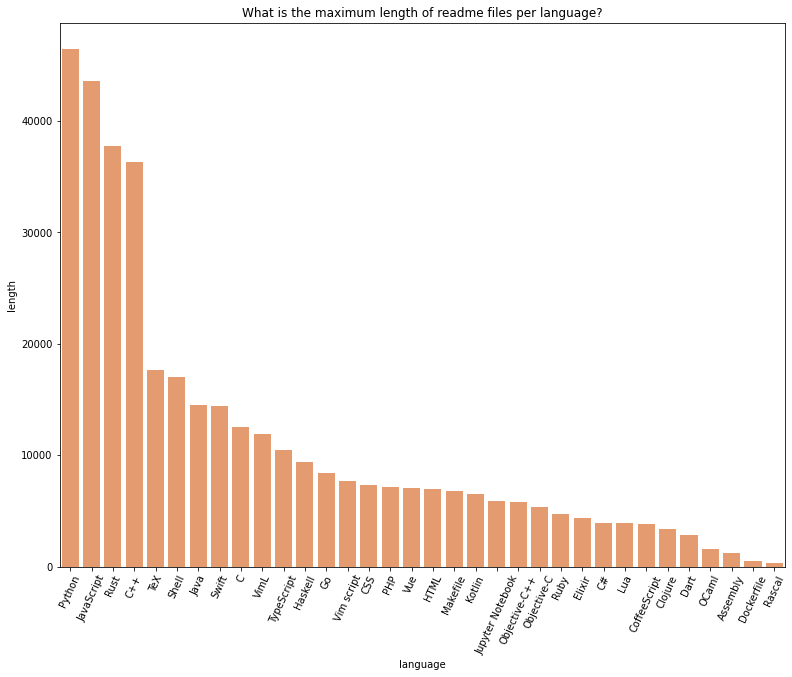

In [23]:
#function to plot the lengths o the readmes for all the languages
explore.bargraphs_for_min_max_median(df)

In [24]:
#Quick dataframe of the top programming languages
explore.word_count_summary(df)

,Min Word Count,Max Word Count,Median Word Count,Mean Word Count,STD of Word Count
is_top_language,,,,,
C++,42,5361,274.5,586.533333,984.070916
Java,19,1975,250.0,303.551020,307.224881
JavaScript,0,6503,312.0,752.292517,1170.338941
Python,3,6563,359.0,938.516667,1399.872131
other,0,5392,279.5,445.075000,555.007845


### Unique Words

**Question:**

Do different programming languages use a different number of unique words?

**Answer:**
- JavaScript seems to have the greatest number of unique words closely followed by our other variable

In [25]:
#use function to create a list of all words for top languages
javascript_words, python_words, java_words, cpp_words, other_words, all_words = explore.list_of_words_for_top_languages(df, language="is_top_language", cleaned="clean_lemmatized")

In [26]:
#print out the unique number of words per language
js_nunique = pd.Series(javascript_words).nunique()
py_nunique = pd.Series(python_words).nunique()
java_nunique = pd.Series(java_words).nunique()
cpp_nunique = pd.Series(cpp_words).nunique()
other_nunique = pd.Series(other_words).nunique()

print(f"Java Script readmes have {js_nunique:,} unique words")
print(f"Pyhton readmes have {py_nunique:,} unique words")
print(f"Java readmes have {java_nunique:,} unique words")
print(f"C++ readmes have {cpp_nunique:,} unique words")
print(f"The other programming languages have {other_nunique:,} unique words in their readmes")

Java Script readmes have 11,087 unique words
Pyhton readmes have 7,631 unique words
Java readmes have 3,414 unique words
C++ readmes have 3,781 unique words
The other programming languages have 10,354 unique words in their readmes


### Bigrams

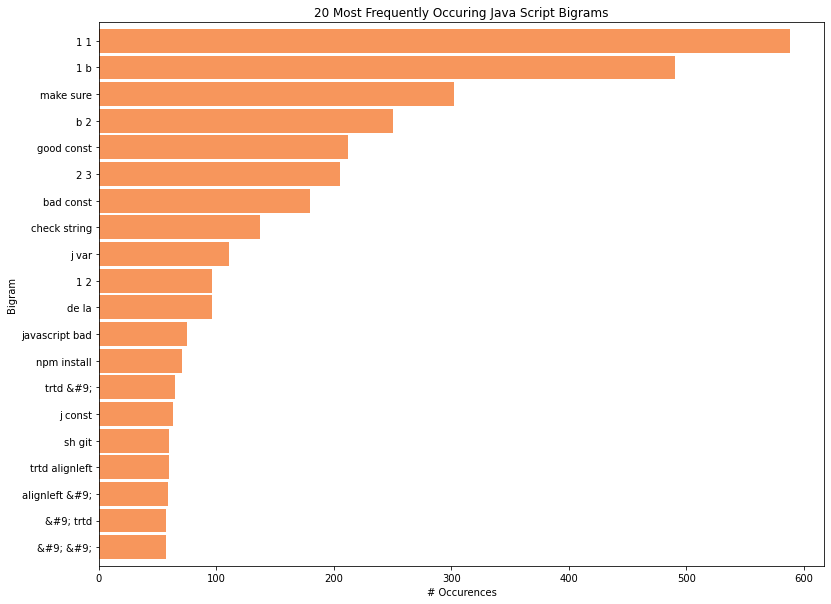

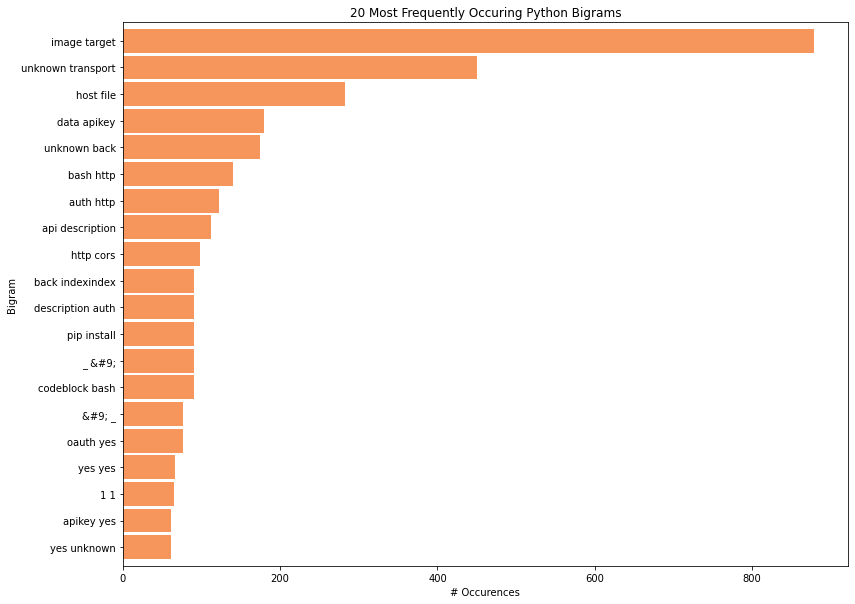

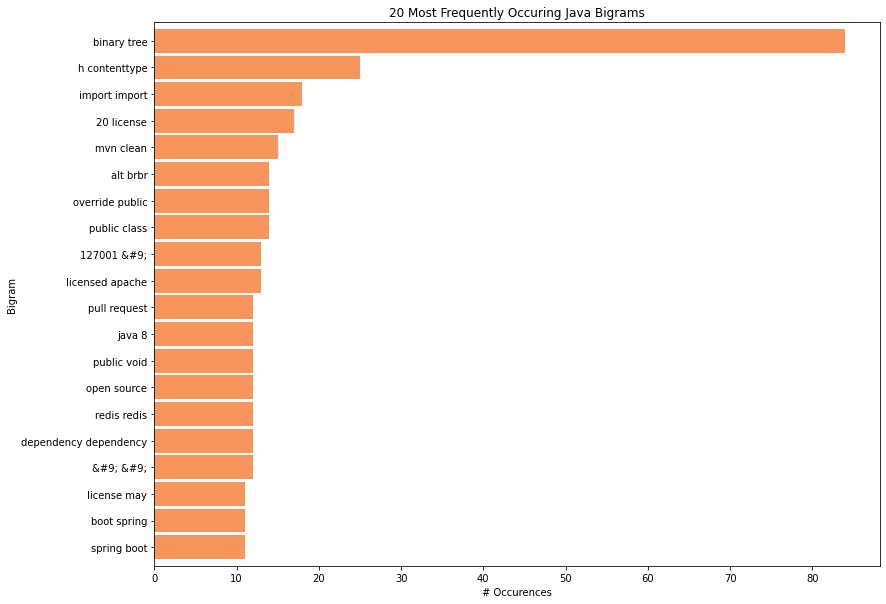

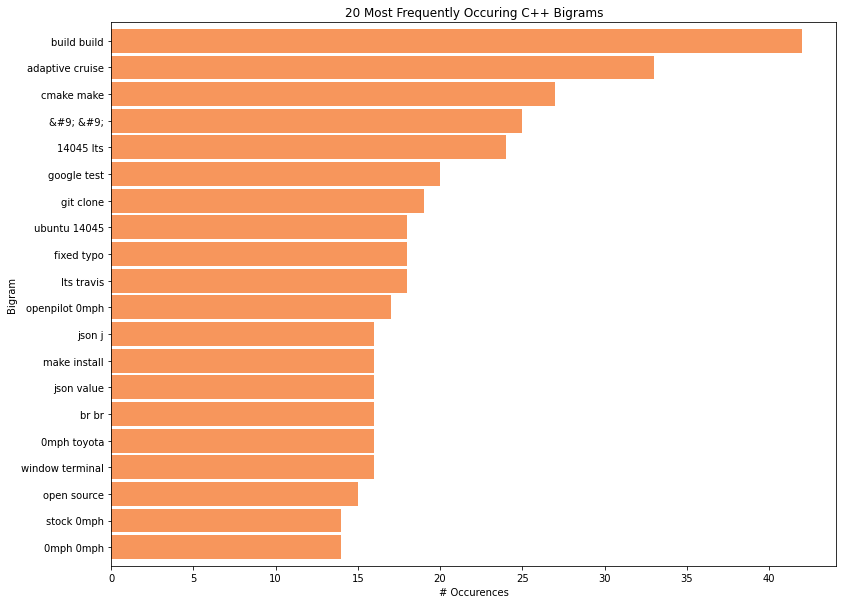

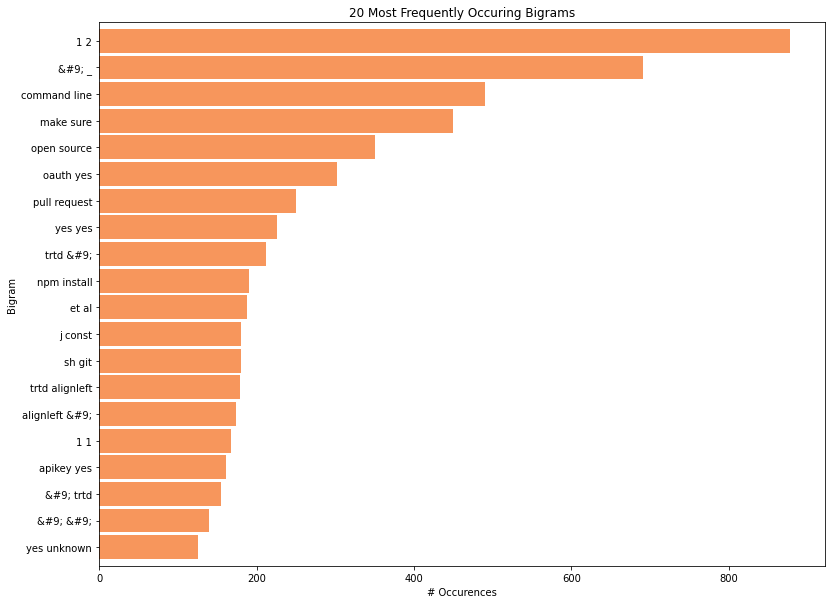

In [27]:
#plot the bigrams for top languages
explore.plot_bigrams(df)

In [28]:
#create list of top 20 bugrams for each variable in top languages
top_20_bigrams, top_20_js_bigrams, top_20_p_bigrams, top_20_j_bigrams, top_20_cpp_bigrams, top_20_other_bigrams = explore.create_bigrams(df)

### Word Clouds

In [29]:
#Java Script word cloud
#explore.word_cloud(javascript_words)

In [30]:
# #Pyhton word cloud
# explore.word_cloud(python_words)

In [31]:
# #Java word cloud
# explore.word_cloud(java_words)

In [32]:
# #C++ word cloud
# explore.word_cloud(cpp_words)

## What are the most common words in READMEs?

In [33]:
df.groupby("is_top_language").clean_lemmatized.agg(["count", explore.most_frequent_word])

,count,most_frequent_word
is_top_language,,
C++,30,build
Java,49,java
JavaScript,147,9
Python,60,yes
other,200,use


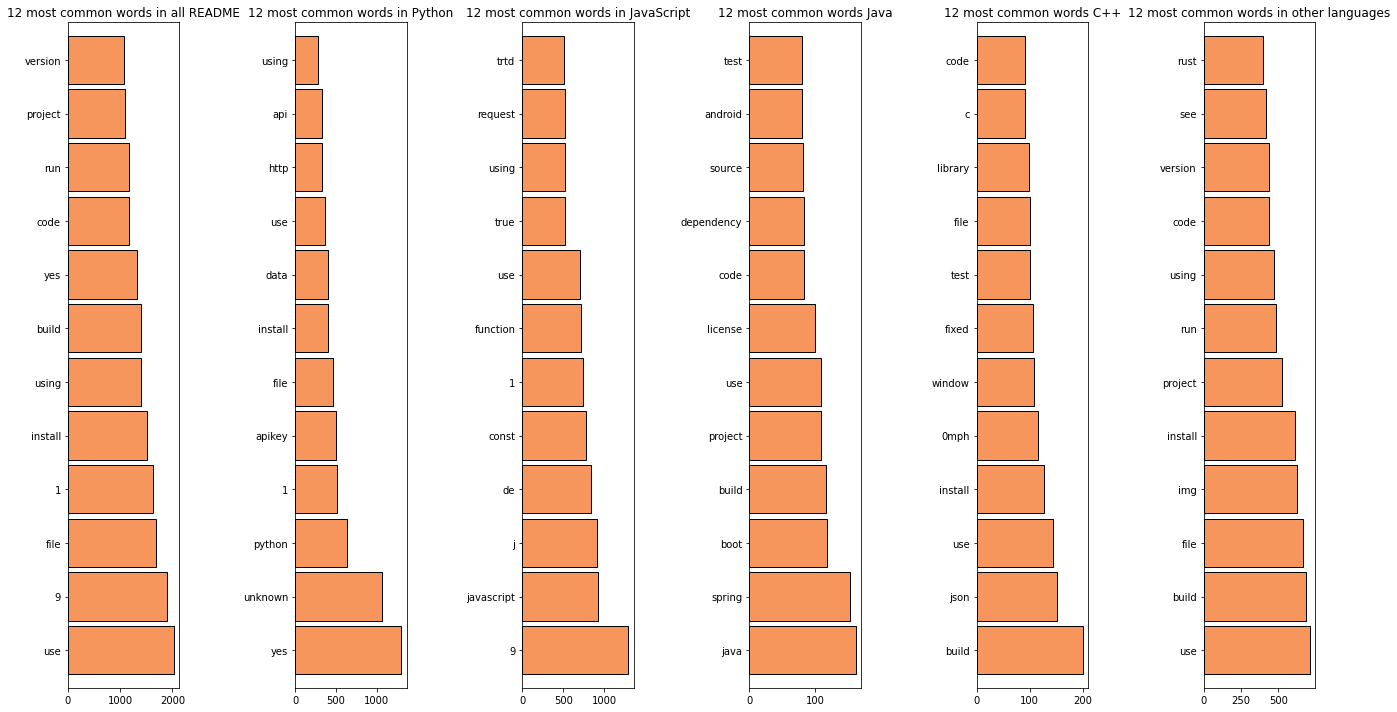

In [34]:
explore.most_common_words(df)

## What does the distribution of IDFs look like for the most common words?

In [35]:
# idf_scores = explore.calculate_idf_score(df)

In [36]:
# f = plt.figure(figsize=(25,20))
# languages = df.is_top_language.unique()
# for count, language in enumerate(languages):

#     f.add_subplot(5,5, count+1)
#     sns.barplot(data=idf_scores[idf_scores.language == language], x=idf_scores[idf_scores.language == language].index, y="idf")
#     plt.title(f"IDF for {language}")
#     plt.xticks(rotation = 45, ha="right")

# plt.tight_layout()

We can see that there might be some problems with the tokenizer, which is leading to some words not being spaced out, as a result, characters are being clump together to create extra longs words, or words with no meaning. I sugest we perhaps don't use this for modeling.

# Is there a difference in the mean number of words by language?

* $H_0$: There is no significant difference between the mean word count of each language when compared with the mean word count of the group.
* $H_a$: There is a significant difference between the mean word count of each language when compared with the mean word count of the group.

$\alpha$ = 0.05

Text(0.5, 1.0, 'Is there a difference in word count across the different languages?')

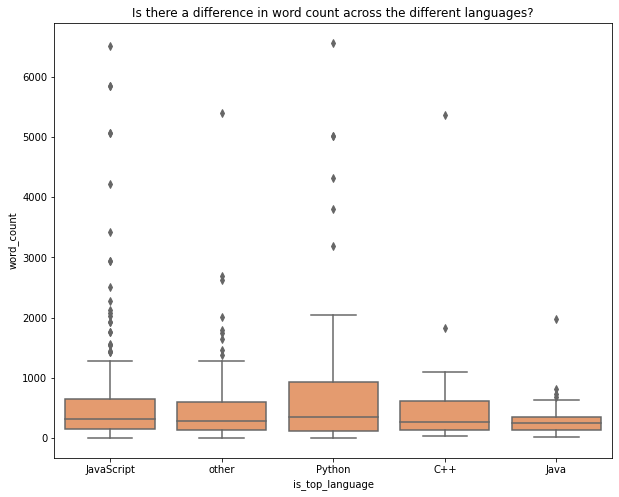

In [80]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df, x='is_top_language', y="word_count", color = "#f7965cff")
plt.title("Is there a difference in word count across the different languages?")

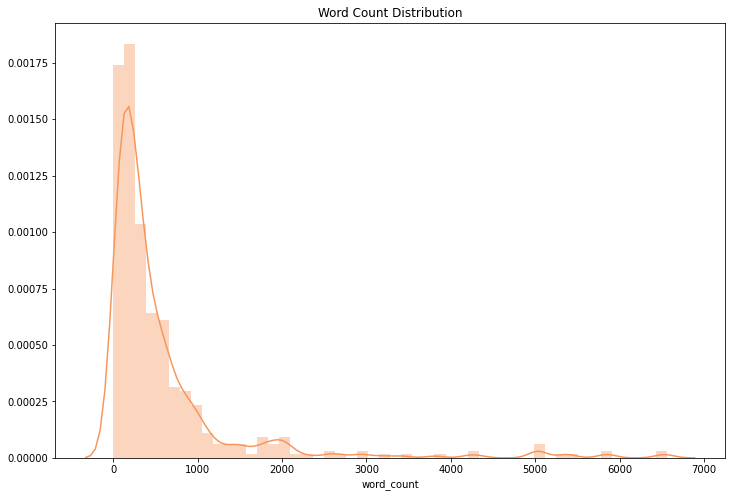

In [38]:
explore.plot_word_count_distribution(df)

It is clear that the word count is not normally distributed. The count is actually right skewed, meaning that most of the word counts by readme are below the average. There seems that there are several outliers that are skewing the data. As such, we likely won't be able to do an accurate t-test, as that requires that the data is normally distributed. 

In [39]:
mean_word_count = df.groupby("is_top_language").word_count.mean()
mean_word_count

is_top_language
C++           586.533333
Java          303.551020
JavaScript    752.292517
Python        938.516667
other         445.075000
Name: word_count, dtype: float64

In [40]:
languages = df.is_top_language.unique()
for language in languages:
    subgroup = df[df.is_top_language == language].word_count
    tsat, p = stats.ttest_1samp(subgroup, df.word_count.mean())
    print(f" The p value for {language} is {p:.2f}")

 The p value for JavaScript is 0.10
 The p value for other is 0.00
 The p value for Python is 0.06
 The p value for C++ is 0.97
 The p value for Java is 0.00


As we can see, the only language that has a word count that is significantly different is `C++`. We can see that, on average, `C++` does have a smaller number of word per readme than the rest. However, given that the data is not normally distributed, we can't trust the results too much.

### Is there a difference in digit count between the languages?

Text(0.5, 1.0, 'What is the digit count distribution?')

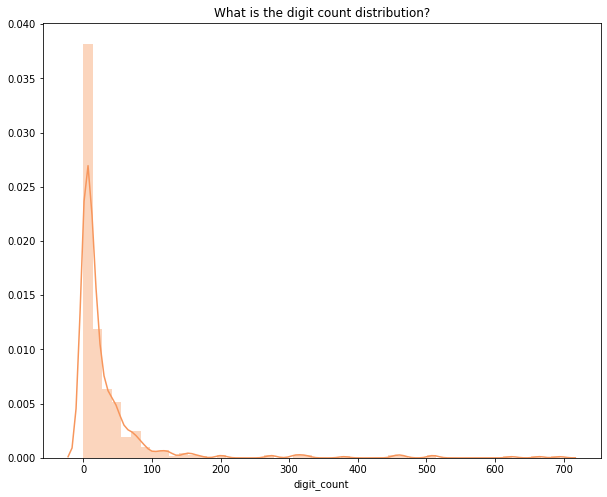

In [41]:
plt.figure(figsize=(10,8))
sns.distplot(df.digit_count, color="#f7965cff")
plt.title("What is the digit count distribution?")

As the we can see, the data is very right skewed, one particularly high outlier. It doesn't make much sense to do a statistical analysis on this feature, as the data is not normally distributed.

Text(0.5, 1.0, 'How does the digit frequency compare in the different languages?')

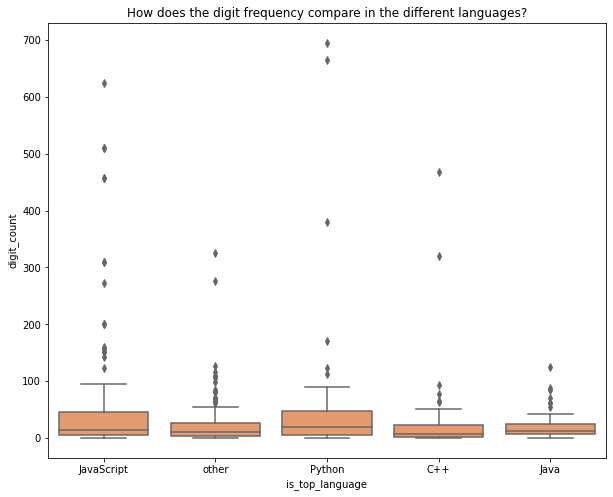

In [79]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x="is_top_language", y="digit_count", color = "#f7965cff")
plt.title("How does the digit frequency compare in the different languages?")

Overall, we see that there is no major difference in mean number of digits across the languages. It might be worth removing the outlier to see if we can get a more clear picture. 

### Sentiment Analysis

Do we see a significance difference in the sentiment analysis between the languages? Is this a feature that we use for modeling?

* $H_0$: There is no significant mean difference between the sentiment of the language and the sentiment of the whole population
* $H_a$: There is a significant mean difference between the sentiment of the language and the sentiment of the whole population

In [43]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()
df["sentiment"] = df.clean_lemmatized.apply(lambda blog: sia.polarity_scores(blog)["compound"])

Text(0.5, 1.0, "Sentiment Analysis of all README's")

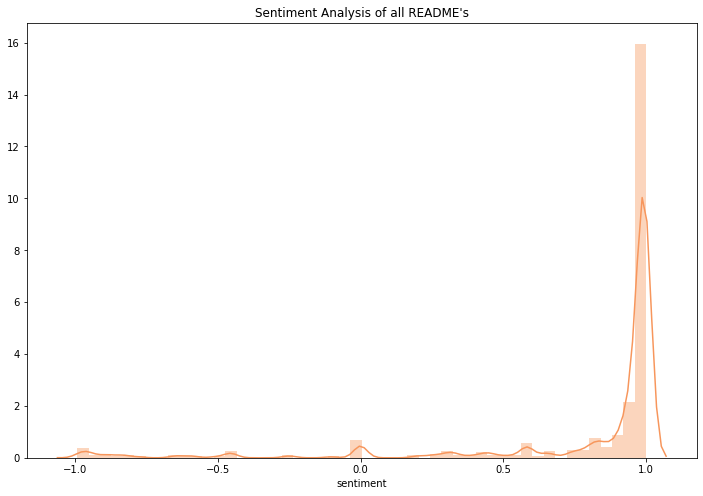

In [78]:
plt.figure(figsize=(12, 8))
sns.distplot(df.sentiment, color = "#f7965cff")
plt.title("Sentiment Analysis of all README's")

Interestingly, it seems that there is an abundance of positive sentiment in the majority of the README's. Initially, we suspected that the majority would likely be `neutral`, as a lot of the coding vernacular is usually descriptive, rather than emotive. We also expected a larger number of negative README's, given that many will state a problem or a frustration, and this would likely be picked up as a negative sentiment. 

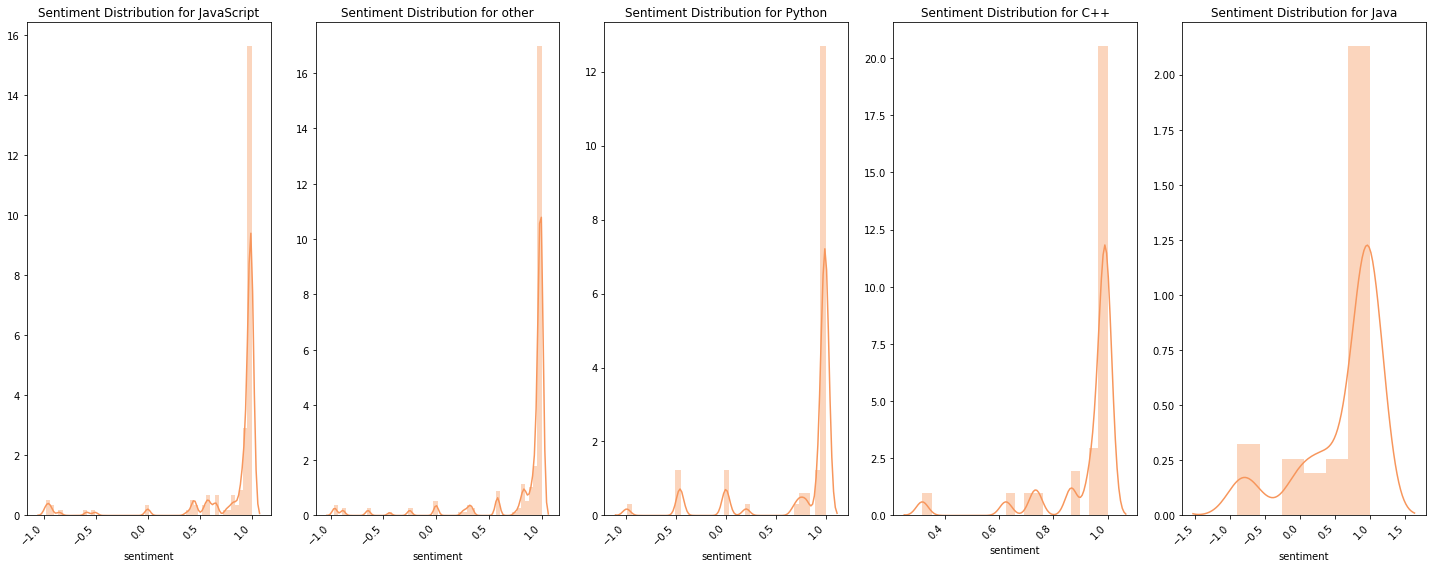

In [77]:
# How does sentiment look across the different languages?

f = plt.figure(figsize=(20,8))
languages = df.is_top_language.unique()

for count, language in enumerate(languages):

    f.add_subplot(1,5, count+1)
    sns.distplot(df[df.is_top_language == language].sentiment, color = "#f7965cff")
    plt.title(f"Sentiment Distribution for {language}")
    plt.xticks(rotation = 45, ha="right")

plt.tight_layout()



As we can see, most languages are actually similar in terms of their overall sentiment, with the majority of README's having a very positive sentiment. 

Some key-takeaways:

* `C++` seems to be the most positive lanuage, given that is has no README's with a sentiment score below zero. This means that most README's are either very positive, or a worst, neautral, but not negative. 
* `Java` seems to have the most normally distributed sentiment. While still left skewed, there are more cases across the spectrum. This is likely because it is a smaller number of cases.

In [46]:
# What are the most frequent bigrams in positive README's?

positive = df[df.sentiment > .8]
positive.groupby("is_top_language").readme_contents.agg(explore.most_frequent_bigram)

is_top_language
C++                    (0mph, 0mph)
Java                 (spring, boot)
JavaScript    (alignlefttdtr, trtd)
Python               (yes, unknown)
other                      (et, al)
Name: readme_contents, dtype: object

In [47]:
# What are the most frequent bigrams in negative README's?

positive = df[df.sentiment < -.8]
positive.groupby("is_top_language").readme_contents.agg(explore.most_frequent_bigram)

is_top_language
Java          (redis, docscodesolvemd)
JavaScript             (algoritmo, de)
Python                    (ndash, fix)
other                 (filetree, view)
Name: readme_contents, dtype: object

In [48]:
# Is there a significant difference in the mean sentiment, by language? 
languages = df.is_top_language.unique()
for language in languages:
    subgroup = df[df.is_top_language == language].sentiment
    tsat, p = stats.ttest_1samp(subgroup, df.sentiment.mean())
    print(f" The p value for {language} is {p:.2f}")

 The p value for JavaScript is 0.72
 The p value for other is 0.32
 The p value for Python is 0.53
 The p value for C++ is 0.00
 The p value for Java is 0.03


Given the large size of the majority of README's - I suspect that the sentiment analysis is probably not going to be very effective. We may try with a different sentiment analyser to see if we can get more accurate results. Unfortunately, given the information at the moment, it seems that sentiment analysis would not be a specially good feature for modeling.

Overall, we see that the only language that seems to have a significantly difference from the group is `C++`. That being said, because the data is left skewed, the statistical significance doesn't really give us as much information. In most, cases, however, we fail to reject the nul hypothesis. 

# Modeling

In [49]:
import model

from sklearn.feature_extraction.text import CountVectorizer 

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [50]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "tf_idf", "is_top_language")
predictions = pd.DataFrame({"actual": y_train, "baseline": y_train.mode()[0]})

### Decision Tree

In [51]:
data_rep = ["bag_of_words", "tf_idf", "bag_of_ngrams"]

for i in data_rep:
    if i == "bag_of_ngrams":
        X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "bag_of_ngrams", "is_top_language", ngram_range = (1,2))
        clf, y_pred = model.run_clf(X_train, y_train, 5)
        score = clf.score(X_train, y_train)
        print(f"{i}, score = {score:.2f}")
    else: 
        
        X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, i, "is_top_language")
        clf, y_pred = model.run_clf(X_train, y_train, 5)
        score = clf.score(X_train, y_train)
        print(f"{i}, score = {score:.2f}")
    

bag_of_words, score = 0.77
tf_idf, score = 0.81
bag_of_ngrams, score = 0.77


In [52]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "tf_idf", "is_top_language")
for i in range(1, 20):
    clf, y_pred = model.run_clf(X_train, y_train, i)
    score = clf.score(X_train, y_train)
    validate_score = clf.score(X_validate, y_validate)
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}")

Max_depth = 1, accuracy_score = 0.54. validate_score = 0.50
Max_depth = 2, accuracy_score = 0.62. validate_score = 0.55
Max_depth = 3, accuracy_score = 0.71. validate_score = 0.62
Max_depth = 4, accuracy_score = 0.77. validate_score = 0.66
Max_depth = 5, accuracy_score = 0.81. validate_score = 0.66
Max_depth = 6, accuracy_score = 0.83. validate_score = 0.65
Max_depth = 7, accuracy_score = 0.86. validate_score = 0.65
Max_depth = 8, accuracy_score = 0.89. validate_score = 0.61
Max_depth = 9, accuracy_score = 0.92. validate_score = 0.61
Max_depth = 10, accuracy_score = 0.93. validate_score = 0.61
Max_depth = 11, accuracy_score = 0.95. validate_score = 0.64
Max_depth = 12, accuracy_score = 0.96. validate_score = 0.61
Max_depth = 13, accuracy_score = 0.96. validate_score = 0.61
Max_depth = 14, accuracy_score = 0.97. validate_score = 0.61
Max_depth = 15, accuracy_score = 0.97. validate_score = 0.65
Max_depth = 16, accuracy_score = 0.98. validate_score = 0.63
Max_depth = 17, accuracy_score = 

In [53]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "tf_idf", "is_top_language")
clf, y_pred = model.run_clf(X_train, y_train, 5)
predictions["decision_tree"] = y_pred

In [54]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.81
            C++  Java  JavaScript  Python  other
C++           4     0           0       0     18
Java          0    32           1       0      4
JavaScript    0     0          91       0     19
Python        0     0           0      29     16
other         0     0          11       0    139


,C++,Java,JavaScript,Python,other,accuracy,macro avg,weighted avg
precision,1.000000,1.000000,0.883495,1.000000,0.709184,0.81044,0.918536,0.844951
recall,0.181818,0.864865,0.827273,0.644444,0.926667,0.81044,0.689013,0.810440
f1-score,0.307692,0.927536,0.854460,0.783784,0.803468,0.81044,0.735388,0.799091
support,22.000000,37.000000,110.000000,45.000000,150.000000,0.81044,364.000000,364.000000


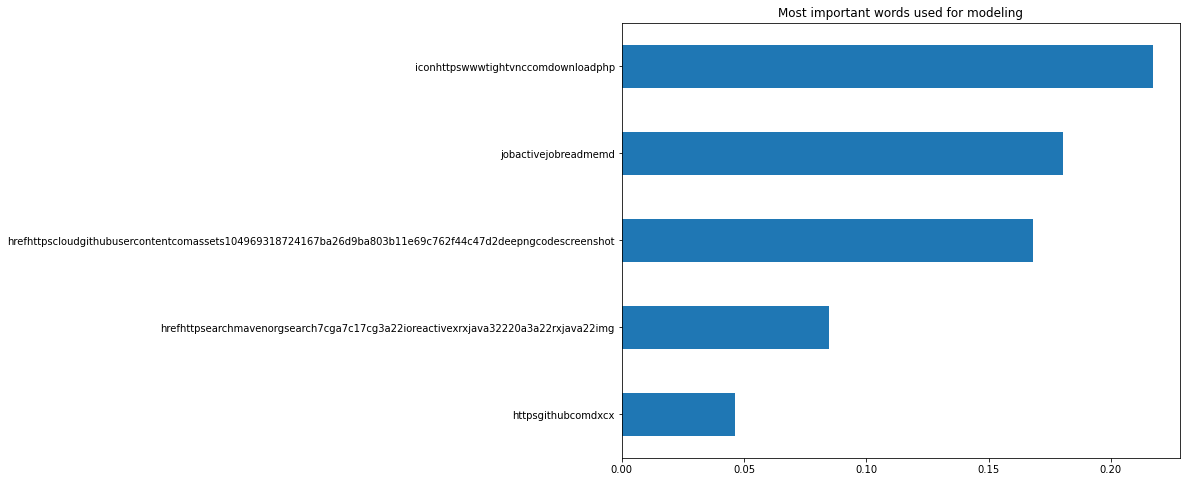

In [55]:
model.preprocessing_features(clf)

### Random Forest

In [56]:
data_rep = ["bag_of_words", "tf_idf", "bag_of_ngrams"]

for i in data_rep:
    X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, i, "is_top_language")
    rf = RandomForestClassifier(random_state= 123, min_samples_leaf = 1, max_depth = 5).fit(X_train, y_train)
    score = rf.score(X_train, y_train)
    print(f"{i}, score = {score}")
    

bag_of_words, score = 0.6208791208791209
tf_idf, score = 0.6181318681318682
bag_of_ngrams, score = 0.4835164835164835


We can see that the best alternative is to use tf_idf for this model

In [57]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "tf_idf", "is_top_language")

In [58]:
for i in range(1, 20):
    rf, y_pred = model.run_rf(X_train, y_train, 2, i)
    score = rf.score(X_train, y_train)
    validate_score = rf.score(X_validate, y_validate)
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}")

Max_depth = 1, accuracy_score = 0.48. validate_score = 0.44
Max_depth = 2, accuracy_score = 0.52. validate_score = 0.44
Max_depth = 3, accuracy_score = 0.54. validate_score = 0.47
Max_depth = 4, accuracy_score = 0.59. validate_score = 0.47
Max_depth = 5, accuracy_score = 0.60. validate_score = 0.48
Max_depth = 6, accuracy_score = 0.65. validate_score = 0.48
Max_depth = 7, accuracy_score = 0.68. validate_score = 0.48
Max_depth = 8, accuracy_score = 0.68. validate_score = 0.49
Max_depth = 9, accuracy_score = 0.71. validate_score = 0.51
Max_depth = 10, accuracy_score = 0.72. validate_score = 0.52
Max_depth = 11, accuracy_score = 0.75. validate_score = 0.54
Max_depth = 12, accuracy_score = 0.77. validate_score = 0.53
Max_depth = 13, accuracy_score = 0.77. validate_score = 0.55
Max_depth = 14, accuracy_score = 0.78. validate_score = 0.52
Max_depth = 15, accuracy_score = 0.81. validate_score = 0.52
Max_depth = 16, accuracy_score = 0.82. validate_score = 0.55
Max_depth = 17, accuracy_score = 

The best score, that doesn't overfit, is a max_depth of 2

In [59]:
rf, y_pred = model.run_rf(X_train, y_train, 1, 14)
predictions["random_forest"] = y_pred

In [60]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.84
            C++  Java  JavaScript  Python  other
C++          12     0           1       0      9
Java          0    25           0       0     12
JavaScript    0     0          86       0     24
Python        0     0           0      34     11
other         0     0           2       0    148


,C++,Java,JavaScript,Python,other,accuracy,macro avg,weighted avg
precision,1.000000,1.000000,0.966292,1.000000,0.725490,0.837912,0.938356,0.876691
recall,0.545455,0.675676,0.781818,0.755556,0.986667,0.837912,0.749034,0.837912
f1-score,0.705882,0.806452,0.864322,0.860759,0.836158,0.837912,0.814715,0.836817
support,22.000000,37.000000,110.000000,45.000000,150.000000,0.837912,364.000000,364.000000


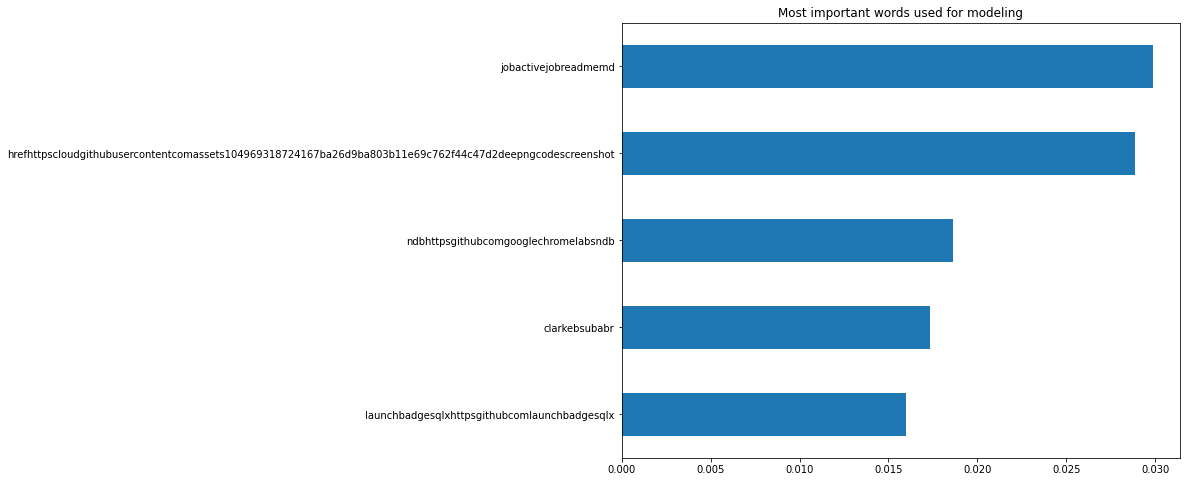

In [61]:
model.preprocessing_features(rf)

### KNN

In [62]:
data_rep = ["bag_of_words", "tf_idf", "bag_of_ngrams"]

for i in data_rep:
    X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, i, "is_top_language")
    knn, y_pred = model.run_knn(X_train, y_train, 5)
    score = knn.score(X_train, y_train)
    print(f"{i}, score = {score}")
    

bag_of_words, score = 0.6978021978021978
tf_idf, score = 0.760989010989011
bag_of_ngrams, score = 0.5631868131868132


In [63]:
for i in range(1, 20):
    knn, y_pred = model.run_knn(X_train, y_train, i)
    score = knn.score(X_train, y_train)
    validate_score = knn.score(X_validate, y_validate)
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}")

Max_depth = 1, accuracy_score = 1.00. validate_score = 0.56
Max_depth = 2, accuracy_score = 0.99. validate_score = 0.41
Max_depth = 3, accuracy_score = 0.96. validate_score = 0.42
Max_depth = 4, accuracy_score = 0.39. validate_score = 0.19
Max_depth = 5, accuracy_score = 0.56. validate_score = 0.38
Max_depth = 6, accuracy_score = 0.57. validate_score = 0.38
Max_depth = 7, accuracy_score = 0.63. validate_score = 0.39
Max_depth = 8, accuracy_score = 0.53. validate_score = 0.36
Max_depth = 9, accuracy_score = 0.48. validate_score = 0.30
Max_depth = 10, accuracy_score = 0.53. validate_score = 0.29
Max_depth = 11, accuracy_score = 0.45. validate_score = 0.19
Max_depth = 12, accuracy_score = 0.36. validate_score = 0.16
Max_depth = 13, accuracy_score = 0.29. validate_score = 0.16
Max_depth = 14, accuracy_score = 0.27. validate_score = 0.15
Max_depth = 15, accuracy_score = 0.55. validate_score = 0.31
Max_depth = 16, accuracy_score = 0.72. validate_score = 0.45
Max_depth = 17, accuracy_score = 

In [64]:
knn, y_pred = model.run_knn(X_train, y_train, 9)
predictions["knn"] = y_pred

In [65]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.48
            C++  Java  JavaScript  Python  other
C++           0     0          21       0      1
Java          0     7          23       1      6
JavaScript    0     0         107       3      0
Python        0     0           8      37      0
other         1     0         125       1     23


,C++,Java,JavaScript,Python,other,accuracy,macro avg,weighted avg
precision,0.0,1.000000,0.376761,0.880952,0.766667,0.478022,0.604876,0.640348
recall,0.0,0.189189,0.972727,0.822222,0.153333,0.478022,0.427494,0.478022
f1-score,0.0,0.318182,0.543147,0.850575,0.255556,0.478022,0.393492,0.406945
support,22.0,37.000000,110.000000,45.000000,150.000000,0.478022,364.000000,364.000000


### Native Bayes Multinomial

In [66]:
data_rep = ["bag_of_words", "tf_idf", "bag_of_ngrams"]

for i in data_rep:
    X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, i, "is_top_language")
    nbm, y_pred = model.run_native_bayes(X_train, y_train, alpha=0.7)
    score = nbm.score(X_train, y_train)
    print(f"{i}, score = {score}")

bag_of_words, score = 0.967032967032967
tf_idf, score = 0.7252747252747253
bag_of_ngrams, score = 0.9945054945054945


In [67]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "bag_of_ngrams", "is_top_language", ngram_range=(1,2))
nbm, y_pred = model.run_native_bayes(X_train, y_train, alpha=0.7)
predictions["native_bayes_multinomial"] = y_pred

In [68]:
accuracy_score, matrix, report = model.accuracy_report(nbm, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 1.00
            C++  Java  JavaScript  Python  other
C++          22     0           0       0      0
Java          0    37           0       0      0
JavaScript    0     0         110       0      0
Python        0     0           0      44      1
other         0     0           0       0    150


,C++,Java,JavaScript,Python,other,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.000000,0.993377,0.997253,0.998675,0.997271
recall,1.0,1.0,1.0,0.977778,1.000000,0.997253,0.995556,0.997253
f1-score,1.0,1.0,1.0,0.988764,0.996678,0.997253,0.997088,0.997242
support,22.0,37.0,110.0,45.000000,150.000000,0.997253,364.000000,364.000000


In [69]:
report = model.create_report(predictions.actual, predictions.decision_tree)

In [70]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

Accuracy Scores
---------------
Actual = 1.00
Baseline = 0.41
Decision_Tree = 0.81
Random_Forest = 0.84
Knn = 0.48
Native_Bayes_Multinomial = 1.00


Key take-aways:
* All models perform better than the baseline, which means implementation of machine learning algorithms for this particular project is an improvement.
* The best performing model is the `Decision Tree` classifier, with an accuracy of 80%
* Given that there is no way to quantify cost, and in this particular case neither recall nor precision are more or less important, we will focus on the general accuracy of the models (given that both metrics are used to calcualte accuracy).

# Evaluation

In [71]:
# Now we will see if the model is overfit

X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "bag_of_ngrams", "is_top_language", ngram_range=(1,2))
nbm, y_pred = model.run_native_bayes(X_train, y_train, alpha=.7)

In [72]:
y_pred = nbm.predict(X_test)

In [73]:
accuracy_score, matrix, report = model.accuracy_report(nbm, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.71
            C++  Java  JavaScript  Python  other
C++           1     0           1       0      6
Java          0     7           0       0      5
JavaScript    2     2          19       0     14
Python        0     1           0      11      3
other         0     0           0       1     49


,C++,Java,JavaScript,Python,other,accuracy,macro avg,weighted avg
precision,0.333333,0.700000,0.950000,0.916667,0.636364,0.713115,0.707273,0.752335
recall,0.125000,0.583333,0.513514,0.733333,0.980000,0.713115,0.587036,0.713115
f1-score,0.181818,0.636364,0.666667,0.814815,0.771654,0.713115,0.614263,0.693135
support,8.000000,12.000000,37.000000,15.000000,50.000000,0.713115,122.000000,122.000000


### Build a function that will take in a text of a README file, and tries to predict the programming language

As part of the specs, we are asked to build a function that can take in any readme, and predict the language. Below is the code used in our function to achieve this. The function takes a README file, as acquuired by the `acquire.py` script. The data is then cleaned and prepared, and the model is fitted, as well as the vectorizer. Then we tranform the new data using the existing vectorizer, and predict using the trained model.



```python
def predict_readme_language(readme):
    df = acquire_data()
    df = prepare_data(df)


    cv = CountVectorizer(ngram_range = (1,2))
    X = cv.fit_transform(df.readme_contents.apply(clean).apply(' '.join))
    y = df["is_top_language"]

    X_train, X_validate, X_test, y_train, y_validate, y_test = split_data(X, y)
    
    mnb = MultinomialNB(alpha = 0.7).fit(X_train, y_train)
       
    text = prepare_data(readme)
    
    X = cv.transform(text.readme_contents.apply(clean).apply(' '.join))
    
    prediction = mnb.predict(X)
    
    return prediction
```

In [74]:
text = df.sample(5).head(1)

In [75]:
text

,repo,language,readme_contents,clean_tokes,clean_lemmatized,is_top_language,word_count,digit_count,sentiment,basic_clean,lemmatized
388,koalaman/shellcheck,Haskell,[![Build Status](https://travis-ci.org/koalama...,"[build, statushttpstravisciorgkoalamanshellche...",build shellcheck shell script static analysis ...,other,1383,53,-0.9529,build statushttpstravisciorgkoalamanshellcheck...,build statushttpstravisciorgkoalamanshellcheck...


In [76]:
# Now we can test the function

prediction = model.predict_readme_language(text)
print(f"This language was likely written in {prediction[0]}")

This language was likely written in other


# Conclusion